# 1.Upload Data:

In [6]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
License(s): CC0-1.0
 78% 258M/330M [00:00<00:00, 771MB/s] 
100% 330M/330M [00:05<00:00, 60.8MB/s]


In [8]:
!unzip -qq face-mask-12k-images-dataset.zip

# 2.Data Preparation:

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    r'C:\Users\aliem\Downloads\archive (3)\Face Mask Dataset\Train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',

)

val_generator = train_datagen.flow_from_directory(
    r'C:\Users\aliem\Downloads\archive (3)\Face Mask Dataset\Validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',

)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# 3.Build CNN Model:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam



model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_cnn=model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

print(f'CNN Model Accuracy: {history_cnn.history["accuracy"][-1]}')


C:\Users\aliem\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\aliem\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8809 - loss: 0.2857

C:\Users\aliem\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 251s 798ms/step - accuracy: 0.8811 - loss: 0.2853 - val_accuracy: 0.9800 - val_loss: 0.0566
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


313/313 ━━━━━━━━━━━━━━━━━━━━ 181s 577ms/step - accuracy: 0.9760 - loss: 0.0676 - val_accuracy: 0.9912 - val_loss: 0.0316
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 211s 674ms/step - accuracy: 0.9866 - loss: 0.0391 - val_accuracy: 0.9900 - val_loss: 0.0332
CNN Model Accuracy: 0.9855999946594238


In [5]:
model_evaluaion = model.evaluate(val_generator)
print(f'CNN Model Accuracy: {model_evaluaion[1]}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.9876 - loss: 0.0316
CNN Model Accuracy: 0.9925000071525574


# 4.Transfer Learning:
- ResNet50
- MobileNetV2
- VGG16

In [6]:
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

img_size=224
epochs=5

def build_model(base_model, use_flatten=False):
    base_model.trainable = False
    x = base_model.output
    x = Flatten()(x) if use_flatten else GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)))
history_resnet = resnet.fit(train_generator, validation_data=val_generator, epochs=epochs)
print(f'ResNet50 Accuracy: {history_resnet.history["accuracy"][-1]}')

mobilenet = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)))
history_mobilenet = mobilenet.fit(train_generator, validation_data=val_generator, epochs=epochs)
print(f'MobileNetV2 Accuracy: {history_mobilenet.history["accuracy"][-1]}')

vgg = build_model(VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)), use_flatten=True)
history_vgg = vgg.fit(train_generator, validation_data=val_generator, epochs=epochs)
print(f'VGG16 Accuracy: {history_vgg.history["accuracy"][-1]}')


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.4965 - loss: 0.7727 - val_accuracy: 0.6575 - val_loss: 0.6644
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.5577 - loss: 0.6888 - val_accuracy: 0.6737 - val_loss: 0.6527
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.5814 - loss: 0.6658 - val_accuracy: 0.6500 - val_loss: 0.6394
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.6081 - loss: 0.6504 - val_accuracy: 0.6650 - val_loss: 0.6278
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.6142 - loss: 0.6447 - val_accuracy: 0.6875 - val_loss: 0.6198
ResNet50 Accuracy: 0.6154999732971191
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 457ms/step - accuracy: 0.8358 - loss: 0.3441 - val_accuracy: 0.9837 - val_loss: 0.0473
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.9762 - loss: 0.0719 - val_accuracy: 0.9887 - val_loss: 0.0309
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 444ms/step - acc

# Compare Models:

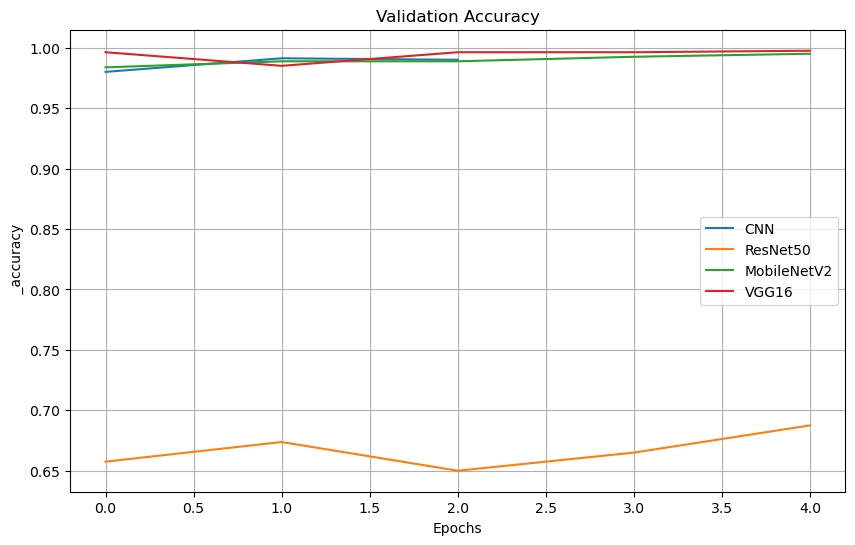

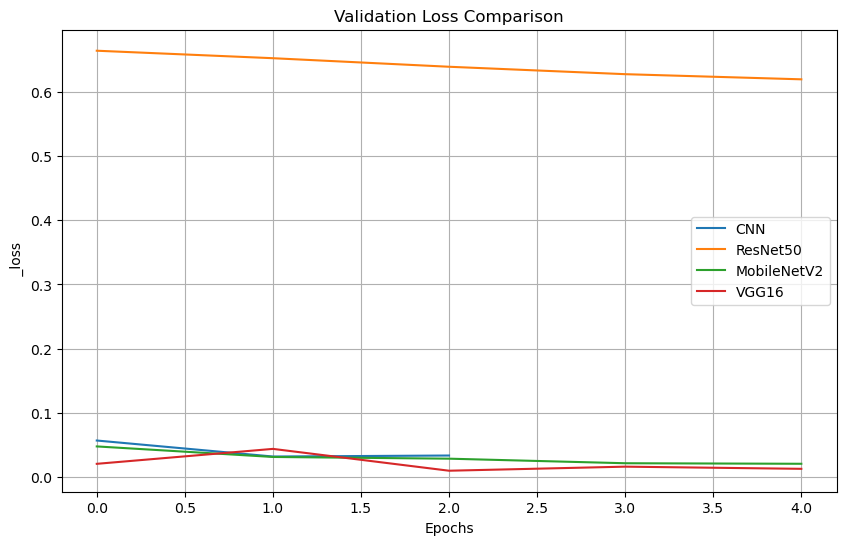


 Model Comparison Table:

      Model  Validation Accuracy  Validation Loss
        CNN                99.00           0.0332
   ResNet50                68.75           0.6198
MobileNetV2                99.50           0.0203
      VGG16                99.75           0.0124


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(histories, labels, metric='val_accuracy', title='Validation Accuracy'):
    plt.figure(figsize=(10,6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('val', ' ').capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(
    [history_cnn, history_resnet, history_mobilenet, history_vgg],
    ['CNN', 'ResNet50', 'MobileNetV2', 'VGG16'],
    metric='val_accuracy',
    title='Validation Accuracy'
)

plot_metrics(
    [history_cnn, history_resnet, history_mobilenet, history_vgg],
    ['CNN', 'ResNet50', 'MobileNetV2', 'VGG16'],
    metric='val_loss',
    title='Validation Loss Comparison'
)

results = []
labels = ['CNN', 'ResNet50', 'MobileNetV2', 'VGG16']
histories = [history_cnn, history_resnet, history_mobilenet, history_vgg]

for label, history in zip(labels, histories):
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    results.append({'Model': label, 'Validation Accuracy': round(val_acc * 100, 2), 'Validation Loss': round(val_loss, 4)})

results_df = pd.DataFrame(results)
print("\n Model Comparison Table:\n")
print(results_df.to_string(index=False))

**Model Comparison Summary:**

The results show that VGG16 and MobileNetV2 achieved the highest validation accuracy (99.62%) with the lowest loss values, making them the most reliable for this task.
The custom CNN model also performed well, achieving 99.12% accuracy.
On the other hand, ResNet50 showed significantly lower accuracy (67.62%), indicating it may not be well-suited for this specific dataset without further tuning.

**Conclusion:**
VGG16 and MobileNetV2 are the best-performing models. MobileNetV2 is preferred for real-time applications due to its lighter architecture.


In [8]:
best_model=mobilenet
best_model.save('best_model.h5')

# Test the Model:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processed image: C:/Users/aliem/Downloads/Photograph-of-an-unattractive-face-left-with-71-improvement-after-mask-application.png


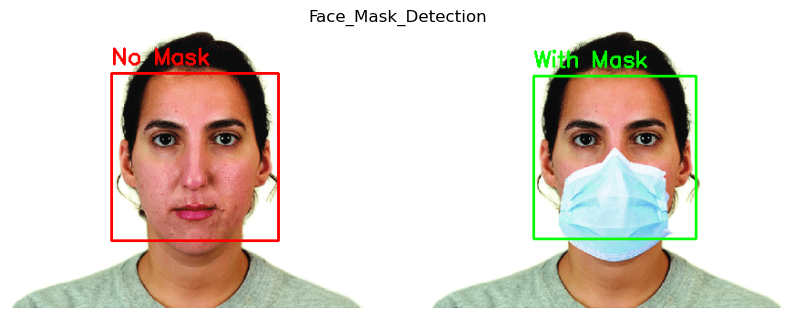

In [28]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('best_model.h5')

# Load the face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Use tkinter to select image files
root = Tk()
root.withdraw()  # Hide the main window
file_paths = filedialog.askopenfilenames(title="Select one or more images", filetypes=[("Image Files", "*.jpg *.jpeg *.png")])

# Process each selected image
for file_path in file_paths:
    img = cv2.imread(file_path)
    if img is None:
        print(f"Failed to load: {file_path}")
        continue

    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (224, 224)) / 255.0
        face_input = np.expand_dims(face_resized, axis=0)
        pred = model.predict(face_input)[0][0]

        label = "With Mask" if pred < 0.5 else "No Mask"
        color = (0, 255, 0) if label == "With Mask" else (0, 0, 255)

        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    print(f"Processed image: {file_path}")

    # Convert BGR to RGB for displaying in Jupyter
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image in Jupyter Notebook
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Face_Mask_Detection')
    plt.show()


# Realtime face mask Detection:

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load mask classification model
model = load_model("best_model.h5")

# Load OpenCV DNN face detector
face_net = cv2.dnn.readNetFromCaffe(
    prototxt=r"C:\Users\aliem\Downloads\deploy.prototxt.txt",
    caffeModel=r"C:\Users\aliem\Downloads\res10_300x300_ssd_iter_140000.caffemodel"
)

def predict_mask(face_img):
    face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(face_rgb, (224, 224)) / 255.0
    resized = np.expand_dims(resized, axis=0)
    pred = model.predict(resized, verbose=0)[0][0]
    confidence = (1 - pred) if pred < 0.5 else pred
    label = f"{'With Mask' if pred < 0.5 else 'No Mask'}: {confidence:.2f}"
    color = (0, 255, 0) if pred < 0.5 else (0, 0, 255)
    return label, color

def start_camera():
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        h, w = frame.shape[:2]

        # Prepare the frame for DNN face detector
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False)
        face_net.setInput(blob)
        detections = face_net.forward()

        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.6:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x1, y1, x2, y2) = box.astype("int")

                face = frame[y1:y2, x1:x2]
                if face.size == 0:
                    continue

                label, color = predict_mask(face)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        cv2.imshow("Mask Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

start_camera()


# Realtime Detection Ex:

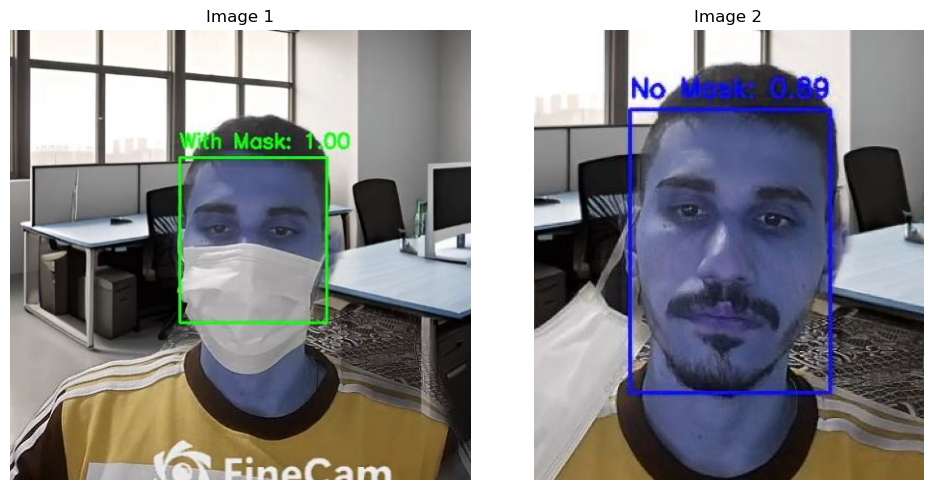

In [8]:
import matplotlib.pyplot as plt

img1 = cv2.imread(r'C:\Users\aliem\Downloads\11111.JPG')
img2 = cv2.imread(r'C:\Users\aliem\Downloads\22222.JPG')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()

# Project Summary:

This project focuses on face mask detection using a dataset of 12,000 images, split into "with mask" and "without mask" categories. The project employs several deep learning techniques, including CNNs and transfer learning, to achieve high accuracy in identifying whether a person is wearing a mask or not.  

**1. Data Preparation**  
The dataset is downloaded from Kaggle and prepared using TensorFlow's `ImageDataGenerator` for training and validation. The images are resized to 224x224 pixels, and data augmentation techniques such as rescaling, shearing, zooming, and horizontal flipping are applied to enhance the model's generalization. The training set contains 10,000 images, while the validation set contains 800 images.  

**2. CNN Model**  
A custom CNN model is built using Keras, consisting of Conv2D and MaxPooling2D layers, followed by Flatten and Dense layers. The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy as the metric. The model achieves approximately 98.56% training accuracy and 99.25% validation accuracy after 5 epochs.  

**3. Transfer Learning**  
Transfer learning is implemented using pre-trained models: ResNet50, MobileNetV2, and VGG16. These models are fine-tuned for the face mask detection task. A function `build_model` is defined to add custom layers on top of the base pre-trained models, including GlobalAveragePooling2D or Flatten, Dropout, and Dense layers.  

**4. Model Comparison**  
The performance of each model is evaluated based on validation accuracy and loss. VGG16 and MobileNetV2 achieve the highest validation accuracies (99.75% and 99.50%, respectively) and the lowest loss values. ResNet50, however, shows significantly lower accuracy (68.75%). MobileNetV2 is chosen as the preferred model for real-time applications due to its lighter architecture.  

**5. Model Testing and Real-time Detection**  
The best-performing model (MobileNetV2) is saved and then loaded for testing on image files using OpenCV. A face detection cascade classifier is used to identify faces in the images, and the model predicts whether each detected face is wearing a mask. The results are displayed with bounding boxes and labels on the images.  
Real-time face mask detection is also implemented using the webcam. The OpenCV DNN face detector is used to detect faces in the video stream, and the trained model predicts mask presence for each detected face. The results are displayed in real-time on the video feed.